# Distributed clustering using Spark

In [1]:
from pyspark import SparkConf, SparkContext
from numpy import argmin, array, all, inf, sqrt, array_equal
import matplotlib.pyplot as plt


### Description
In principle we need to distribute all memory demanding tasks. we will not be able to:
- plot all datapoints
- load all batches locally

based from: https://runawayhorse001.github.io/LearningApacheSpark/clustering.html

In [2]:
# Create spark session
sc = SparkContext(conf=SparkConf().setAppName("kmedoidsDistributed"))

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/01/18 14:44:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/01/18 14:44:09 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
23/01/18 14:46:18 ERROR YarnClientSchedulerBackend: The YARN application has already ended! It might have been killed or the Application Master may have failed to start. Check the YARN application logs for more details.
23/01/18 14:46:18 ERROR SparkContext: Error initializing SparkContext.
org.apache.spark.SparkException: Application application_1673133383379_0040 was killed by user ubuntu at 192.168.4.83
	at org.apache.spark.scheduler.cluster.YarnClientSchedulerBackend.waitForApplication(YarnClientSchedulerBackend.scala:98)
	at org.apache.spark.scheduler.cluster.YarnClientSchedulerBackend.start(YarnClientSchedulerBackend.s

Py4JJavaError: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: org.apache.spark.SparkException: Application application_1673133383379_0040 was killed by user ubuntu at 192.168.4.83
	at org.apache.spark.scheduler.cluster.YarnClientSchedulerBackend.waitForApplication(YarnClientSchedulerBackend.scala:98)
	at org.apache.spark.scheduler.cluster.YarnClientSchedulerBackend.start(YarnClientSchedulerBackend.scala:65)
	at org.apache.spark.scheduler.TaskSchedulerImpl.start(TaskSchedulerImpl.scala:222)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:585)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:238)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


In [3]:
# configurations
filename = "/home/ubuntu/protein/sampled_embeddings_reduced.csv"


In [4]:
# Convert the data into an RDD
data = sc.textFile(filename).map(lambda line: array([float(x) for x in line.split(',')[1:]]))

# Initialize the medoids randomly
k = 3
medoids = data.takeSample(False, k, 1)

# Define a function to calculate the distance between a data point and a medoid
def distance(point, medoid):
    return sqrt(sum((point - medoid) ** 2))

# Assign each data point to the closest medoid
def closest_medoid(point):
    return argmin([distance(point, medoid) for medoid in medoids])

def updateMedoids(data):
    new_medoids = []
    for j in range(k):
        clusterPoints = data.filter(lambda point: closest_medoid(point) == j)
        new_medoids.append(array(clusterPoints.reduce(lambda a, b: a + b)) / clusterPoints.count())
    return new_medoids

converged = False
iterations = 0
max_iterations = 2

while not converged and iterations < max_iterations:
    closest = data.map(closest_medoid)
    new_medoids = updateMedoids(data)
    converged = all([array_equal(a, b) for a, b in zip(new_medoids, medoids)])
    medoids = new_medoids
    iterations += 1



23/01/18 13:52:38 WARN TransportChannelHandler: Exception in connection from /192.168.4.135:45224
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:258)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:722)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:658)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoo

In [5]:
# Compute the silhouette score
silhouette = 0
for i in range(k):
    # Compute the mean distance to the other points in the same cluster
    a = data.filter(lambda point: closest_medoid(point) == i)\
        .map(lambda point: distance(point, medoids[i])).mean()
    # Compute the mean distance to the points in the next closest cluster
    b = inf
    for j in range(k):
        if i != j:
            b = min(b, data.filter(lambda point: closest_medoid(point) == j)\
                .map(lambda point: distance(point, medoids[i])).mean())
    # Compute the silhouette score for this point
    silhouette += (b - a) / max(a, b)

# Average the silhouette scores
silhouette /= data.count()

print("Silhouette score = " + str(silhouette))

Silhouette score = 2.8939540020894115e-06


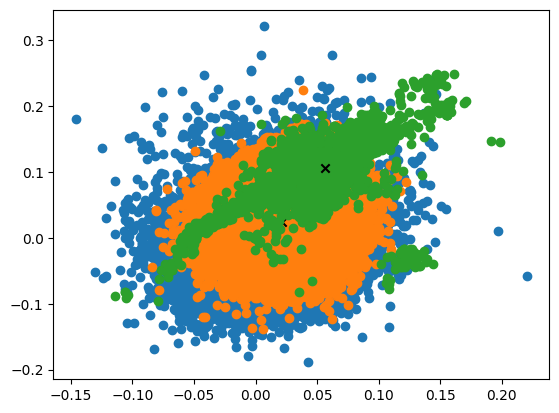

23/01/16 15:03:39 ERROR YarnClientSchedulerBackend: YARN application has exited unexpectedly with state KILLED! Check the YARN application logs for more details.
23/01/16 15:03:39 ERROR YarnClientSchedulerBackend: Diagnostics message: Application application_1673133383379_0029 was killed by user ubuntu at 192.168.4.83
23/01/16 15:03:39 WARN TransportChannelHandler: Exception in connection from /192.168.3.64:50138
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:258)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel

In [6]:
for i in range(k):
    clusterPoints = data.filter(lambda point: closest_medoid(point) == i)
    x, y = zip(*[(point[0], point[1]) for point in clusterPoints.collect()])
    plt.scatter(x, y)
    plt.scatter(medoids[i][0], medoids[i][1], c='black', marker='x')

plt.show()